##1. Import **Libraries**

In [92]:
import numpy as np
import pandas as pd
import spacy
import pickle
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##2. Data Downloading

In [3]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 13.7 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset
import pandas as pd
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string 
stop = stopwords.words('english')


def get_dataset(x):
    data = load_dataset("/content/drive/MyDrive/ColabNotebooks/tools/yahoo_answers_topics.py")
    df=pd.DataFrame(data[x])
    df['text']=df['question_title']+df['question_content']+df['best_answer']
    return df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# dftrain=get_dataset('train')
# # dftest=get_dataset('test')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
# def process_series(series, stop):
#     series = series.str.lower().str.replace('[^\w\s]', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#     return series

In [23]:
# dftrain['alltext']=dftrain['question_title']+dftrain['question_content']+dftrain['best_answer']
# # dftest['alltext']=dftest['question_title']+dftest['question_content']+dftest['best_answer']

In [24]:
# dftrain['cleanedtext']=process_series(dftrain['alltext'],stop)
# # dftest['cleanedtext']=process_series(dftest['alltext'],stop)

<ipython-input-19-28c81e8a02ee>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  series = series.str.lower().str.replace('[^\w\s]', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
<ipython-input-19-28c81e8a02ee>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  series = series.str.lower().str.replace('[^\w\s]', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [26]:
# dftrain.to_csv('/content/drive/MyDrive/ColabNotebooks/data/train.csv')

In [27]:
# dftest.to_csv('/content/drive/MyDrive/ColabNotebooks/data/test.csv')

##3. Data Visualization

##4. Preprocessing Data

In [2]:
# # !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [3]:
df=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data/yahoo_train.csv')

In [21]:
df=df[df.topic.isin([0,1,2])]

In [22]:
df=df[df['text_clean'].convert_dtypes(convert_string=True).notnull()]

In [23]:
cleaned_data=df['text_clean'].to_list()

In [24]:
len(cleaned_data)

420000

In [25]:
b_file = open("/content/drive/MyDrive/ColabNotebooks/data/cleaned_data.pkl", "wb")
pickle.dump(cleaned_data, b_file)
b_file.close()

In [74]:
def encoding_data(cleaned_data):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(cleaned_data)

    # word_index is a dictionary contains indeces for the words like {'for': 8, 'is': 9, 'me': 10, ...}
    word_index = tokenizer.word_index

    # train_sequences is vectors where each vector represents a sentence
    data_sequences = tokenizer.texts_to_sequences(cleaned_data)
    data_sequences = pad_sequences(data_sequences, maxlen=10, padding="post")



    with open("/content/drive/MyDrive/ColabNotebooks/data/tokenizer.pkl","wb") as file:
        pickle.dump(tokenizer,file)

    return data_sequences, word_index
#------------------------------------------------------------------#
data_sequences, word_index = encoding_data(cleaned_data)

with open("/content/drive/MyDrive/ColabNotebooks/data/data_sequences.pkl","wb") as file:
    pickle.dump(data_sequences,file)

with open("/content/drive/MyDrive/ColabNotebooks/data/word_index.pkl","wb") as file:
    pickle.dump(word_index,file)

##5. Importing GloVe dataset

In [75]:
!pip install wget
import wget
url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

def GloVe(data = 'glove.6B.100d.txt'):

  embeddings_index={}
  with open(data, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
  return embeddings_index
#--------------------------------------------------------------------------------------------#
def embeddingWeights(word_index, max_num_words=500000):
  embeddings_index = GloVe()
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std()

  num_words = min(max_num_words, len(word_index))+1

  embedding_dim=len(embeddings_index['the'])
  
  embedding_weights = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

  for word, i in word_index.items():
      if i >= max_num_words:
          break
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_weights[i] = embedding_vector
  
  return embedding_weights, num_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
embedding_weights, num_words = embeddingWeights(word_index)

a_file = open("/content/drive/MyDrive/ColabNotebooks/data/embedding_wights.pkl", "wb")
pickle.dump(embedding_weights, a_file)
a_file.close()

a_file = open("/content/drive/MyDrive/ColabNotebooks/data/num_words.pkl", "wb")
pickle.dump(num_words, a_file)
a_file.close()

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [77]:
# # # Importing all the variables from Google Drive
# with open('/content/drive/MyDrive/ColabNotebooks/data/cleaned_data.pkl','rb') as file:
#   cleaned_data = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/data_label.pkl','rb') as file:
# #   data_label = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/data_sequences.pkl','rb') as file:
#   data_sequences = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/dic.pkl','rb') as file:
# #   dic = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/label_encoder.pkl','rb') as file:
# #   label_encoder = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/num_words.pkl','rb') as file:
#   num_words = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/tokenizer.pkl','rb') as file:
#   tokenizer = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/word_index.pkl','rb') as file:
#   word_index = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/embedding_wights.pkl','rb') as file:
#   embedding_wights = pickle.load(file)

In [78]:
df['topic'].value_counts()

2    140000
1    140000
0    140000
Name: topic, dtype: int64

In [79]:
data_label=df['topic'].to_numpy()

In [80]:
data_sequences.shape,data_sequences.dtype

((420000, 10), dtype('int32'))

In [81]:
data_label.shape

(420000,)

##6. Splitting the Data

In [82]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data_sequences, data_label,test_size = 0.2, stratify=data_label)
test_data, val_data, test_labels, val_labels = train_test_split(val_test_data, val_test_labels, test_size = 0.5, stratify=val_test_labels)

##7. Model Preparation and Training

In [83]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, trainable=False, input_length=10, weights=[embedding_weights]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), 'concat'))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss ='sparse_categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [84]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 10, 100)           45499500  
                                                                 
 bidirectional_6 (Bidirectio  (None, 10, 512)          731136    
 nal)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 128)           328192    
                                                                 
 dropout_25 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                      

In [85]:
stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose = 1, factor = 0.1, min_delta=0.001, min_lr = 0.00001)

history = model.fit(train_data, train_labels, epochs = 2,
          batch_size = 1024, shuffle=True,
          validation_data=[val_data, val_labels],
          callbacks=[reduce_lr, stopping])

model.save('/content/drive/MyDrive/ColabNotebooks/data/model.h5')

Epoch 1/2
165/165 [==============================] - 994s 6s/step - loss: 0.7529 - accuracy: 0.6695 - val_loss: 0.5941 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 2/2
165/165 [==============================] - 938s 6s/step - loss: 0.6004 - accuracy: 0.7564 - val_loss: 0.5681 - val_accuracy: 0.7689 - lr: 0.0010


In [86]:
model.evaluate(test_data, test_labels)

1313/1313 [==============================] - 82s 62ms/step - loss: 0.5648 - accuracy: 0.7710


[0.5648202300071716, 0.7710475921630859]

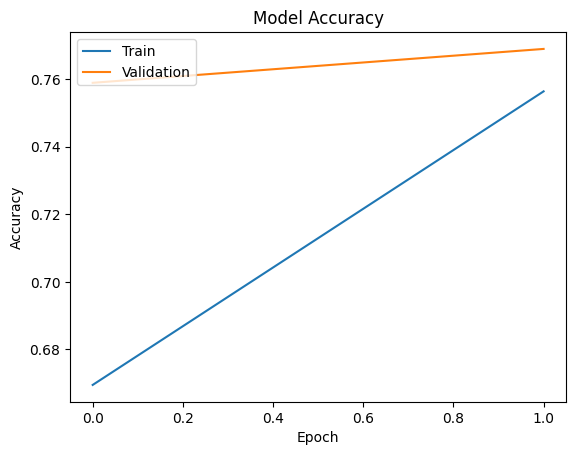

In [87]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

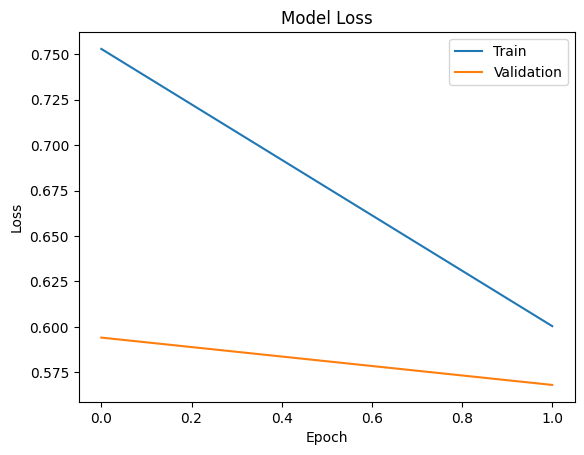

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [91]:
#getting some more metrics for the model

# predict crisp classes for test set
yhat_classes = model.predict(test_data, verbose=0)
 

array([[0.02614317, 0.03410772, 0.939749  ],
       [0.368098  , 0.04593507, 0.5859668 ],
       [0.9262358 , 0.0574751 , 0.01628915],
       ...,
       [0.13666415, 0.61301553, 0.25032035],
       [0.34697688, 0.04532418, 0.6076989 ],
       [0.00747196, 0.9841633 , 0.0083647 ]], dtype=float32)

In [95]:
yhat_classes=np.argmax(yhat_classes, axis=-1)

In [101]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, yhat_classes,average='macro')
print('Precision: ',precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, yhat_classes,average='macro')
print('Recall:' , recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, yhat_classes,average='macro')
print('F1 score:' ,f1)
 
# kappa
kappa = cohen_kappa_score(test_labels, yhat_classes)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(test_labels, yhat_classes)
print(matrix)

Accuracy: 0.771048
Precision:  0.7777950282419658
Recall: 0.7710476190476191
F1 score: 0.7713595806231336
Cohens kappa: 0.656571
[[11567   953  1480]
 [ 2017 10092  1891]
 [ 2484   791 10725]]
